# Introduction

This notebook presents various ways to solve bandits problems, including 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Environment

In [2]:
class BanditEnv:
    def __init__(self):
        """10-armed testbed, see chapter 2.3"""
        self.size = 10                                        # 10 arms
        self.means = np.array([0.25, -0.75, 1.5, 0.5, 1.25,   # eyeball fig 2.1
                               -1.5, -0.25, -1, 0.75, -0.5])
    def step(self, action):
        return np.random.normal(loc=self.means[action])

Helpers

In [3]:
def argmax_rand(arr):
    assert isinstance(arr, np.ndarray)
    assert len(arr.shape) == 1
    
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == arr.max()))

In [4]:
# see e.g. here: https://deepnotes.io/softmax-crossentropy
def softmax(x):
    """Numerically stable softmax"""
    max_ = np.max(x, axis=-1, keepdims=True)       #                  shape: (n_batch, 1)
    ex = np.exp(x - max_)                          #                  shape: (n_batch, n_out)
    ex_sum = np.sum(ex, axis=-1, keepdims=True)    #                  shape: (n_batch, 1)
    return ex / ex_sum                             # probabilities    shape: (n_batch, n_out)

In [5]:
def regret(env, hist_R):
    assert isinstance(env.means, np.ndarray)
    assert len(env.means.shape) == 1
    assert isinstance(hist_R, np.ndarray)
    assert len(hist_R.shape) == 1
    
    Q_max = env.means.max()                          # max mean
    hist_R_max = Q_max * np.ones(shape=len(hist_R))  # omniscient agent
    regret_per_step = hist_R_max - hist_R
    return regret_per_step

In [6]:
def plot_Q(env, Q):
    assert env.size == int(env.size)
    assert isinstance(env.means, np.ndarray)
    assert len(env.means.shape) == 1
    assert isinstance(Q, np.ndarray)
    assert len(Q.shape) == 1
    assert len(env.means) == len(Q)
    
    plt.scatter(range(env.size), env.means, color='blue', marker='o', label='true')
    plt.scatter(range(env.size), Q, color='red', marker='x', label='Q')
    plt.legend()
    plt.show()

In [7]:
def plot_experiments(data, color, axes=None):
    """
    Params:
        data (np.ndarray): experiment results, shape: [nb_exp, len_exp]
        color (str or tuple): matplotlib compatible color definition
        axes (tuple of two np.)
    """
    assert isinstance(data, np.ndarray)
    assert len(data.shape) == 2
    assert axes is None or len(axes) == 2
    #assert axes is None or isinstance(axex[0], plt.Axes)
    #assert axes is None or isinstance(axex[1], plt.Axes)
    
    if axes is None:
        _, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    else:
        ax1, ax2 = axes

    x = range(data.shape[1])
    means = data.mean(axis=0)
    stds = data.std(axis=0)

    ax1.plot(x, data.T, c=color, alpha=0.1)

    ax2.plot(x, means, c=color)
    ax2.fill_between(x, means-stds, means+stds, color=color, alpha=0.1)

    if axes is None:
        plt.tight_layout()
        plt.show()
    
    return axes

In [8]:
def plot_regret(env, hist_regret):
    plt.plot(np.cumsum(hist_regret))
    plt.show()

In [10]:
def explore_then_commit(env, nb_total, nb_explore):
    hist_A = []
    hist_R = []
    
    assert nb_explore % env.size == 0
    
    Q = np.zeros(env.size)
    N = np.zeros(env.size)
    
    for k in range(nb_total):
        if k <= nb_explore:
            A = k % env.size
            R = env.step(A)
            
            N[A] += 1                
            Q[A] += (1/N[A]) * (R - Q[A])
        else:
            A = argmax_rand(Q)
            R = env.step(A)
        
        
        hist_A.append(A)
        hist_R.append(R)
    
    return Q, np.array(hist_A), np.array(hist_R)

In [23]:
env = BanditEnv()
Q, hist_A, hist_R = explore_then_commit(env, nb_total=10000, nb_explore=100)

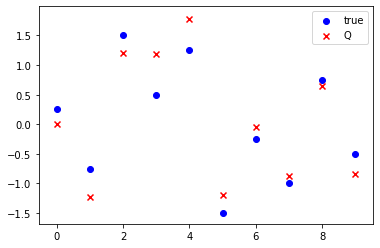

In [24]:
plot_Q(env, Q)

In [13]:
regret_explore_commit = regret(env, hist_R)

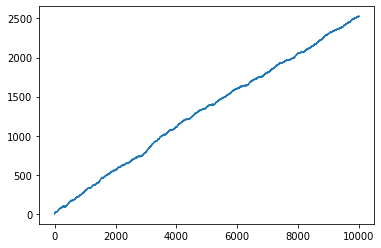

In [14]:
plot_regret(env, regret_explore_commit)

In [ ]:
plot_experiments(experiment_results['UCB'], 'blue', axes)

In [21]:
def epsilon_greedy(env, nb_total, eps, eps_factor=1.0):
    hist_A = []
    hist_R = []
    hist_e = []
    
    Q = np.zeros(env.size)
    N = np.zeros(env.size)
    
    for _ in range(nb_total):
        A = argmax_rand(Q) if np.random.rand() > eps else np.random.randint(env.size)             
        R = env.step(A)    
        N[A] += 1                
        Q[A] += (1/N[A]) * (R - Q[A])
        
        eps *= eps_factor
        
        hist_A.append(A)
        hist_R.append(R)
        hist_e.append(eps)
        
    return Q, np.array(hist_A), np.array(hist_R), np.array(hist_e)

In [28]:
Q, hist_A, hist_R, hist_e = epsilon_greedy(env, nb_total=10000, eps=0.1)

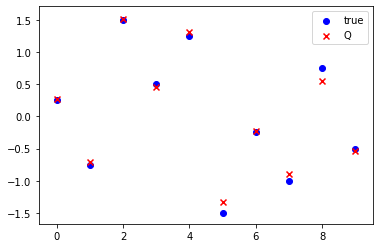

In [29]:
plot_Q(env, Q)

In [30]:
regret_epsilon_greedy = regret(env, hist_R)

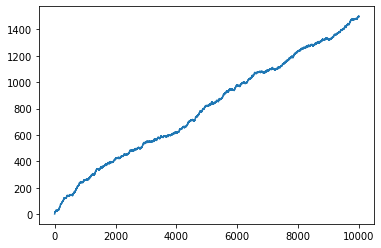

In [31]:
plot_regret(env, regret_epsilon_greedy)

In [41]:
Q, hist_A, hist_R, hist_e = epsilon_greedy(env, nb_total=10000, eps=1, eps_factor=0.999)

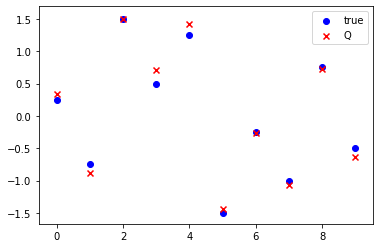

In [42]:
plot_Q(env, Q)

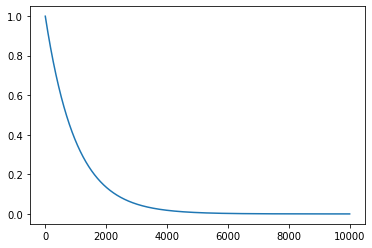

In [43]:
plt.plot(hist_e)

In [44]:
regret_epsilon_greedy_anneal = regret(env, hist_R)

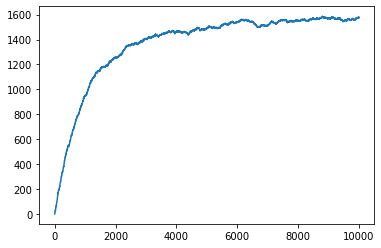

In [45]:
plot_regret(env, regret_epsilon_greedy_anneal)

In [46]:
def upper_confidence_bound(env, nb_total, c_param):
    hist_A = []
    hist_R = []
    
    V = np.zeros(env.size)
    N = np.zeros(env.size)
    
    for k in range(nb_total):
        
        if k < env.size:
            A = k
        else:
            scores = V/N + c_param * np.sqrt( np.log(N.sum()) / N )
            A = argmax_rand(scores)
        
        R = env.step(A)
        
        N[A] += 1
        V[A] += R
        
        hist_A.append(A)
        hist_R.append(R)
    
    Q = V / N
    return Q, np.array(hist_A), np.array(hist_R)

In [47]:
Q, hist_A, hist_R = upper_confidence_bound(env, nb_total=10000, c_param=np.sqrt(2))

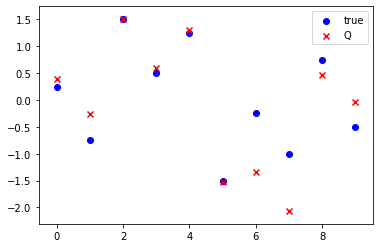

In [48]:
plot_Q(env, Q)

In [49]:
regret_UCB = regret(env, hist_R)

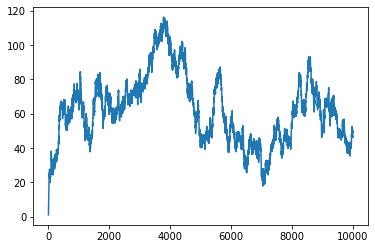

In [50]:
plot_regret(env, regret_UCB)

In [224]:
experiment_results = {}

In [225]:
def run_experiment(num_runs, algorithm, **kwargs):
    experiment_results = []  # shape [num_runs, nb_total]
    for _ in range(num_runs):
        Q, hist_A, hist_R = algorithm(**kwargs)
        experiment_results.append(np.cumsum(regret(env, hist_R)))
    experiment_results = np.array(experiment_results)
    return experiment_results

In [226]:
res = run_experiment(10, upper_confidence_bound, env=env, nb_total=10000, c_param=np.sqrt(2))
experiment_results['UCB'] = res

In [214]:
def upper_confidence_bound_priors(env, nb_total, c_param, priors):
    hist_A = []
    hist_R = []
    
    V = np.zeros(env.size)
    N = np.zeros(env.size)
    Q = np.zeros(env.size)
    
    for k in range(nb_total):
        
        scores = Q + c_param * priors * np.sqrt(N.sum())/(1+N)
        A = argmax_rand(scores)
        
        R = env.step(A)
        
        N[A] += 1
        V[A] += R
        Q[A] = V[A] / N[A]
        
        hist_A.append(A)
        hist_R.append(R)
    
    return Q, np.array(hist_A), np.array(hist_R)

In [215]:
priors = softmax(env.means)
print(priors)

[0.08299839 0.0305334  0.28969284 0.10657204 0.22561301 0.01442296
 0.05034107 0.02377944 0.13684121 0.03920566]


In [217]:
Q, hist_A, hist_R = upper_confidence_bound_priors(env, nb_total=10000, c_param=np.sqrt(2), priors=priors)

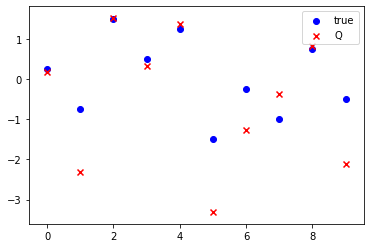

In [218]:
plot_Q(env, Q)

In [219]:
regret_UCB_priors = regret(env, hist_R)

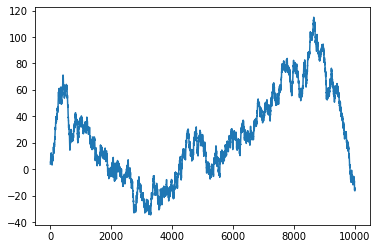

In [220]:
plot_regret(env, regret_UCB_priors)

In [249]:
res = run_experiment(10, upper_confidence_bound_priors, env=env, nb_total=10000, c_param=np.sqrt(2), priors=priors)
experiment_results['UCB_priors'] = res

In [255]:
axes[0]

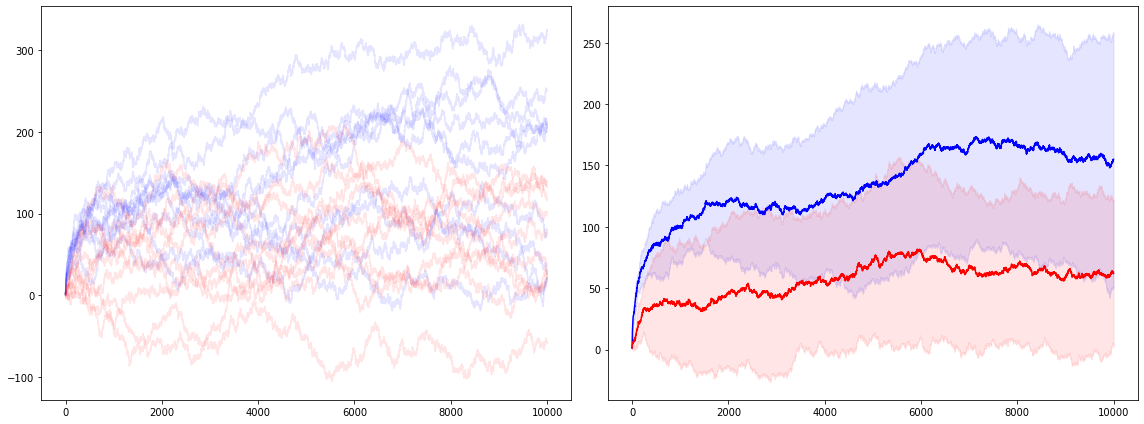

In [258]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
plot_experiments(experiment_results['UCB'], 'blue', axes)
plot_experiments(experiment_results['UCB_priors'], 'red', axes)
plt.tight_layout()
plt.show()